### Note

Please view the [README](https://github.com/deeplearning4j/dl4j-examples/tree/overhaul_tutorials/tutorials/README.md) to learn about installing, setting up dependencies, and importing notebooks in Zeppelin.

### Background

Deep learning is the de facto standard for face recognition. In 2015, Google researchers published [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832), which set a new record for accuracy of 99.63% on the [LFW dataset](http://vis-www.cs.umass.edu/lfw/). An important aspect of FaceNet is that it made face recognition more practical by using the [embeddings](https://en.wikipedia.org/wiki/Embedding) to learn a mapping of face features to a compact Euclidean space (basically, you input an image and get a small 1D array from the network). FaceNet was an adapted version of an [Inception-style](https://arxiv.org/abs/1409.4842) network.

Around the same time FaceNet was being developed, other research groups were making significant advances in facial recognition. [DeepID3](https://arxiv.org/abs/1502.00873), for example, achieved impressive results. Oxford's Visual Geometry Group published [Deep Face Recognition](https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf). Note that the *Deep Face Recognition* paper has a comparison of previous papers, and one key factor in FaceNet is the number of images used to train the network: 200 million.

#### Introducing center loss

FaceNet is difficult to train, partially because of how it uses triplet loss. This required exotic architectures that either set up three models in tandem, or required stacking of examples and unstacking with additional nodes to calculate loss based on euclidean similarity. [A Discriminative Feature Learning Approach for Deep Face Recognition](https://ydwen.github.io/papers/WenECCV16.pdf) introduced center loss, a promising technique that added an *intraclass* component to a training loss function.

<center>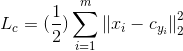<br></center>


The advantage of training embeddings with center loss is that an exotic architecture is no longer required. In addition, because hardware is better utilized, the amount of time it takes to train embeddings is much shorter. One important distinction when using center loss vs. a triplet loss architecture is that a center loss layer stores its own parameters. These parameters calculate the intraclass "center" of all examples for each label.

### What are we going to learn in this tutorial?

Using Deeplearning4j, you will learn how to train embeddings for facial recognition and transfer parameters to a new network that uses the embeddings for feed forward. The network will be built using `ComputationGraph` (Inception-type networks require multiple nodes) via the [OpenFace NN4.Small2](https://github.com/deeplearning4j/deeplearning4j/blob/e2d5a854d743a4783367dff969d3c0bff8097a54/deeplearning4j-zoo/src/main/java/org/deeplearning4j/zoo/model/FaceNetNN4Small2.java) variant, which is a hand-tuned, parameter-minimized model of FaceNet.

Because Inception networks are large, we will use the Deeplearning4j model zoo to help build our network. If you have imported this notebook into a fresh installation of Zeppelin, make sure you add the `deeplearning4j-zoo` artifact to the Spark interpreter. See this [README](https://github.com/deeplearning4j/dl4j-examples/tree/master/tutorials#setting-up-dependencies) for instructions.

### Imports

In [4]:
import org.datavec.image.loader.LFWLoader
// import org.deeplearning4j.zoo.model.FaceNetNN4Small2
import org.deeplearning4j.zoo.model.helper.FaceNetHelper;
import org.deeplearning4j.zoo._
import org.deeplearning4j.nn.graph.ComputationGraph
import org.deeplearning4j.nn.conf._
import org.deeplearning4j.optimize.listeners.ScoreIterationListener
import org.deeplearning4j.datasets.iterator.impl.LFWDataSetIterator
import org.deeplearning4j.nn.transferlearning.TransferLearning
import org.nd4j.linalg.activations.Activation
import org.nd4j.linalg.learning.config.Adam
import org.deeplearning4j.nn.api.OptimizationAlgorithm
import org.deeplearning4j.nn.weights.WeightInit
import org.deeplearning4j.nn.conf.layers._
import org.deeplearning4j.nn.conf.graph.L2NormalizeVertex
import org.deeplearning4j.nn.conf.graph.MergeVertex
import org.nd4j.linalg.lossfunctions.LossFunctions
import org.deeplearning4j.nn.conf.inputs.InputType
import org.deeplearning4j.nn.conf.WorkspaceMode

import scala.collection.JavaConversions._
import scala.collection.JavaConverters._
import java.util.Random

### Instantiate the model

We are using a minified version of the full FaceNet network to reduce the hardware requirements. Below, we use the `FaceNetHelper` class for some of the Inception blocks, where parameters have been unchanged from the larger version.

In [6]:
val batchSize = 48 // depending on your hardware, you will want to increase or decrease
val numExamples = LFWLoader.NUM_IMAGES
val outputNum = LFWLoader.NUM_LABELS // number of "identities" in the dataset
val splitTrainTest = 1.0
val randomSeed = 123;
val iterations = 1; // this is almost always 1
val transferFunction = Activation.RELU
val inputShape = Array[Int](3,96,96)

// val zooModel = new FaceNetNN4Small2(outputNum, randomSeed, iterations)
// val net = zooModel.init().asInstanceOf[ComputationGraph]

def graphConf(): ComputationGraphConfiguration = {
    val embeddingSize = 128
    
    val graph = new NeuralNetConfiguration.Builder()
    .seed(randomSeed)
    .iterations(iterations)
    .activation(Activation.IDENTITY)
    .optimizationAlgo(OptimizationAlgorithm.STOCHASTIC_GRADIENT_DESCENT)
    .updater(new Adam(0.1, 0.9, 0.999, 0.01)).weightInit(WeightInit.RELU).l2(5e-5)
    .miniBatch(true).convolutionMode(ConvolutionMode.Same)
    .inferenceWorkspaceMode(WorkspaceMode.SEPARATE)
    .trainingWorkspaceMode(WorkspaceMode.SEPARATE)
    .graphBuilder
    
    graph
    .addInputs("input1")
    .addLayer("stem-cnn1", new ConvolutionLayer.Builder(Array[Int](7,7), Array[Int](2,2), Array[Int](3,3)).nIn(inputShape(0)).nOut(64).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "input1")
    .addLayer("stem-batch1", new BatchNormalization.Builder(false).nIn(64).nOut(64).build, "stem-cnn1").addLayer("stem-activation1", new ActivationLayer.Builder().activation(Activation.RELU).build, "stem-batch1")
    .addLayer("stem-pool1", new SubsamplingLayer.Builder(SubsamplingLayer.PoolingType.MAX, Array[Int](3, 3), Array[Int](2, 2), Array[Int](1, 1)).build, "stem-activation1")
    .addLayer("stem-lrn1", new LocalResponseNormalization.Builder(1, 5, 1e-4, 0.75).build, "stem-pool1")
    .addLayer("inception-2-cnn1", new ConvolutionLayer.Builder(1,1).nIn(64).nOut(64).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "stem-lrn1")
    .addLayer("inception-2-batch1", new BatchNormalization.Builder(false).nIn(64).nOut(64).build, "inception-2-cnn1")
    .addLayer("inception-2-activation1", new ActivationLayer.Builder().activation(Activation.RELU).build, "inception-2-batch1")
    .addLayer("inception-2-cnn2", new ConvolutionLayer.Builder(Array[Int](3, 3), Array[Int](1, 1), Array[Int](1, 1)).nIn(64).nOut(192).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "inception-2-activation1").addLayer("inception-2-batch2", new BatchNormalization.Builder(false).nIn(192).nOut(192).build, "inception-2-cnn2")
    .addLayer("inception-2-activation2", new ActivationLayer.Builder().activation(Activation.RELU).build, "inception-2-batch2")
    .addLayer("inception-2-lrn1", new LocalResponseNormalization.Builder(1, 5, 1e-4, 0.75).build, "inception-2-activation2")
    .addLayer("inception-2-pool1", new SubsamplingLayer.Builder(SubsamplingLayer.PoolingType.MAX, Array[Int](3, 3), Array[Int](2, 2), Array[Int](1, 1)).build, "inception-2-lrn1")

    // Inception 3a
    FaceNetHelper.appendGraph(graph, "3a", 192, Array[Int](3, 5), Array[Int](1, 1), Array[Int](128, 32), Array[Int](96, 16, 32, 64), SubsamplingLayer.PoolingType.MAX, transferFunction, "inception-2-pool1")

    // Inception 3b
    FaceNetHelper.appendGraph(graph, "3b", 256, Array[Int](3, 5), Array[Int](1, 1), Array[Int](128, 64), Array[Int](96, 32, 64, 64), SubsamplingLayer.PoolingType.PNORM, 2, transferFunction, "inception-3a")

    // Inception 3c
    graph.addLayer("3c-1x1", new ConvolutionLayer.Builder(Array[Int](1, 1), Array[Int](1, 1)).nIn(320).nOut(128).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "inception-3b").addLayer("3c-1x1-norm", FaceNetHelper.batchNorm(128, 128), "3c-1x1").addLayer("3c-transfer1", new ActivationLayer.Builder().activation(transferFunction).build, "3c-1x1-norm").addLayer("3c-3x3", new ConvolutionLayer.Builder(Array[Int](3, 3), Array[Int](2, 2)).nIn(128).nOut(256).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "3c-transfer1").addLayer("3c-3x3-norm", FaceNetHelper.batchNorm(256, 256), "3c-3x3").addLayer("3c-transfer2", new ActivationLayer.Builder().activation(transferFunction).build, "3c-3x3-norm").addLayer("3c-2-1x1", new ConvolutionLayer.Builder(Array[Int](1, 1), Array[Int](1, 1)).nIn(320).nOut(32).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "inception-3b").addLayer("3c-2-1x1-norm", FaceNetHelper.batchNorm(32, 32), "3c-2-1x1").addLayer("3c-2-transfer3", new ActivationLayer.Builder().activation(transferFunction).build, "3c-2-1x1-norm").addLayer("3c-2-5x5", new ConvolutionLayer.Builder(Array[Int](3, 3), Array[Int](2, 2)).nIn(32).nOut(64).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "3c-2-transfer3").addLayer("3c-2-5x5-norm", FaceNetHelper.batchNorm(64, 64), "3c-2-5x5").addLayer("3c-2-transfer4", new ActivationLayer.Builder().activation(transferFunction).build, "3c-2-5x5-norm").addLayer("3c-pool", new SubsamplingLayer.Builder(SubsamplingLayer.PoolingType.MAX, Array[Int](3, 3), Array[Int](2, 2), Array[Int](1, 1)).build, "inception-3b").addVertex("inception-3c", new MergeVertex, "3c-transfer2", "3c-2-transfer4", "3c-pool")
    
    // Inception 4a
    FaceNetHelper.appendGraph(graph, "4a", 640, Array[Int](3, 5), Array[Int](1, 1), Array[Int](192, 64), Array[Int](96, 32, 128, 256), SubsamplingLayer.PoolingType.PNORM, 2, transferFunction, "inception-3c")

    // Inception 4e
    graph
    .addLayer("4e-1x1", new ConvolutionLayer.Builder(Array[Int](1, 1), Array[Int](1, 1)).nIn(640).nOut(160).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "inception-4a")
    .addLayer("4e-1x1-norm", FaceNetHelper.batchNorm(160, 160), "4e-1x1").addLayer("4e-transfer1", new ActivationLayer.Builder().activation(transferFunction).build, "4e-1x1-norm")
    .addLayer("4e-3x3", new ConvolutionLayer.Builder(Array[Int](3, 3), Array[Int](2, 2)).nIn(160).nOut(256).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "4e-transfer1")
    .addLayer("4e-3x3-norm", FaceNetHelper.batchNorm(256, 256), "4e-3x3").addLayer("4e-transfer2", new ActivationLayer.Builder().activation(transferFunction).build, "4e-3x3-norm")
    .addLayer("4e-2-1x1", new ConvolutionLayer.Builder(Array[Int](1, 1), Array[Int](1, 1)).nIn(640).nOut(64).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "inception-4a")
    .addLayer("4e-2-1x1-norm", FaceNetHelper.batchNorm(64, 64), "4e-2-1x1").addLayer("4e-2-transfer3", new ActivationLayer.Builder().activation(transferFunction).build, "4e-2-1x1-norm")
    .addLayer("4e-2-5x5", new ConvolutionLayer.Builder(Array[Int](3, 3), Array[Int](2, 2)).nIn(64).nOut(128).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "4e-2-transfer3")
    .addLayer("4e-2-5x5-norm", FaceNetHelper.batchNorm(128, 128), "4e-2-5x5").addLayer("4e-2-transfer4", new ActivationLayer.Builder().activation(transferFunction).build, "4e-2-5x5-norm")
    .addLayer("4e-pool", new SubsamplingLayer.Builder(SubsamplingLayer.PoolingType.MAX, Array[Int](3, 3), Array[Int](2, 2), Array[Int](1, 1)).build, "inception-4a")
    .addVertex("inception-4e", new MergeVertex, "4e-transfer2", "4e-2-transfer4", "4e-pool")

    // Inception 5a
    graph
    .addLayer("5a-1x1", new ConvolutionLayer.Builder(Array[Int](1, 1), Array[Int](1, 1)).nIn(1024).nOut(256).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "inception-4e")
    .addLayer("5a-1x1-norm", FaceNetHelper.batchNorm(256, 256), "5a-1x1")
    .addLayer("5a-transfer1", new ActivationLayer.Builder().activation(transferFunction).build, "5a-1x1-norm")
    .addLayer("5a-2-1x1", new ConvolutionLayer.Builder(Array[Int](1, 1), Array[Int](1, 1)).nIn(1024).nOut(96).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "inception-4e")
    .addLayer("5a-2-1x1-norm", FaceNetHelper.batchNorm(96, 96), "5a-2-1x1").addLayer("5a-2-transfer2", new ActivationLayer.Builder().activation(transferFunction).build, "5a-2-1x1-norm")
    .addLayer("5a-2-3x3", new ConvolutionLayer.Builder(Array[Int](3, 3), Array[Int](1, 1)).nIn(96).nOut(384).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "5a-2-transfer2")
    .addLayer("5a-2-3x3-norm", FaceNetHelper.batchNorm(384, 384), "5a-2-3x3").addLayer("5a-transfer3", new ActivationLayer.Builder().activation(transferFunction).build, "5a-2-3x3-norm").addLayer("5a-3-pool", new SubsamplingLayer.Builder(SubsamplingLayer.PoolingType.PNORM, Array[Int](3, 3), Array[Int](1, 1)).pnorm(2).build, "inception-4e")
    .addLayer("5a-3-1x1reduce", new ConvolutionLayer.Builder(Array[Int](1, 1), Array[Int](1, 1)).nIn(1024).nOut(96).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "5a-3-pool")
    .addLayer("5a-3-1x1reduce-norm", FaceNetHelper.batchNorm(96, 96), "5a-3-1x1reduce").addLayer("5a-3-transfer4", new ActivationLayer.Builder().activation(Activation.RELU).build, "5a-3-1x1reduce-norm")
    .addVertex("inception-5a", new MergeVertex, "5a-transfer1", "5a-transfer3", "5a-3-transfer4")
    
    // Inception 5b
    graph
    .addLayer("5b-1x1", new ConvolutionLayer.Builder(Array[Int](1, 1), Array[Int](1, 1)).nIn(736).nOut(256).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "inception-5a")
    .addLayer("5b-1x1-norm", FaceNetHelper.batchNorm(256, 256), "5b-1x1").addLayer("5b-transfer1", new ActivationLayer.Builder().activation(transferFunction).build, "5b-1x1-norm")
    .addLayer("5b-2-1x1", new ConvolutionLayer.Builder(Array[Int](1, 1), Array[Int](1, 1)).nIn(736).nOut(96).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "inception-5a")
    .addLayer("5b-2-1x1-norm", FaceNetHelper.batchNorm(96, 96), "5b-2-1x1").addLayer("5b-2-transfer2", new ActivationLayer.Builder().activation(transferFunction).build, "5b-2-1x1-norm")
    .addLayer("5b-2-3x3", new ConvolutionLayer.Builder(Array[Int](3, 3), Array[Int](1, 1)).nIn(96).nOut(384).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "5b-2-transfer2")
    .addLayer("5b-2-3x3-norm", FaceNetHelper.batchNorm(384, 384), "5b-2-3x3").addLayer("5b-2-transfer3", new ActivationLayer.Builder().activation(transferFunction).build, "5b-2-3x3-norm")
    .addLayer("5b-3-pool", new SubsamplingLayer.Builder(SubsamplingLayer.PoolingType.MAX, Array[Int](3, 3), Array[Int](1, 1), Array[Int](1, 1)).build, "inception-5a")
    .addLayer("5b-3-1x1reduce", new ConvolutionLayer.Builder(Array[Int](1, 1), Array[Int](1, 1)).nIn(736).nOut(96).cudnnAlgoMode(ConvolutionLayer.AlgoMode.NO_WORKSPACE).build, "5b-3-pool")
    .addLayer("5b-3-1x1reduce-norm", FaceNetHelper.batchNorm(96, 96), "5b-3-1x1reduce").addLayer("5b-3-transfer4", new ActivationLayer.Builder().activation(transferFunction).build, "5b-3-1x1reduce-norm").addVertex("inception-5b", new MergeVertex, "5b-transfer1", "5b-2-transfer3", "5b-3-transfer4")
    
    // output
    graph
    .addLayer("avgpool", new SubsamplingLayer.Builder(SubsamplingLayer.PoolingType.AVG, Array[Int](3, 3), Array[Int](3, 3)).build, "inception-5b")
    .addLayer("bottleneck", new DenseLayer.Builder().nIn(736).nOut(embeddingSize).activation(Activation.IDENTITY).build, "avgpool")
    .addVertex("embeddings", new L2NormalizeVertex(Array[Int](), 1e-6), "bottleneck")
    .addLayer("lossLayer", new CenterLossOutputLayer.Builder().lossFunction(LossFunctions.LossFunction.SQUARED_LOSS).activation(Activation.SOFTMAX).nIn(128).nOut(outputNum).lambda(1e-4).alpha(0.9).gradientNormalization(GradientNormalization.RenormalizeL2PerLayer).build, "embeddings")
    .setOutputs("lossLayer")
    .backprop(true).pretrain(false)
    .setInputTypes(InputType.convolutional(inputShape(2), inputShape(1), inputShape(0)))
    
    graph.build
}

val net = new ComputationGraph(graphConf())

net.setListeners(new ScoreIterationListener(1))

### Print the configuration

To see that Center Loss if already in the model configuration, you can print a string table of all layers in the network. Use the `summary()` method to get a complete summary of all layers and parameters. You'll see that our network here has over 5 million parameters, this is still quite low compared to advanced ImageNet configurations, but will still be taxing on your hardware.

In [8]:
println(net.summary())

### Using the LFW iterator

The `LFWDataSetIterator`, like most of the Deeplearning4j built-in iterators, extends the `DataSetIterator` class. This API allows for the simple instantiation of datasets and automatic downloading of data in the background. If you are unfamiliar with using DL4J's built-in iterators, there's a tutorial describing their usage.

In [10]:
val inputWHC = Array[Int](inputShape(2), inputShape(1), inputShape(0))

val iter = new LFWDataSetIterator(batchSize, numExamples, inputWHC, outputNum, false, true, splitTrainTest, new Random(randomSeed))

 

### Classifier training

With the network configruation is set up and instantiated along with the LFW test/train iterators, training takes just a few lines of code. Since we have a labelled dataset and are using center loss, this is considered "classifier training" and is a supervised learning process.

Earlier we attached a `ScoreIterationListener` to the model by using the `setListeners()` method. Depending on the browser used to run this notebook, you can open the debugger/inspector to view listener output. This output is redirected to the console since the internals of Deeplearning4j use SL4J for logging, and the output is being redirected by Zeppelin. This is a good thing since it can reduce clutter in notebooks.

After each epoch, we will evaluate how well the network is learning by using the `evaluate()` method. Although in this example we only use `accuracy()` and `precision()`, it is strongly recommended you perform advanced evaluation with ROC curves and understand the output of a confusion matrix.

In [12]:
// the "simple" way to do multiple epochs is to wrap fit() in a loop
val nEpochs = 30
(1 to nEpochs).foreach{ epoch =>
    // training
    net.fit(iter)
    println("Epoch " + epoch + " complete");
    
    // here you will want to pass an iterator that contains your test set
    // val eval = net.evaluate(testIter)
    // println(s"""Accuracy: ${eval.accuracy()} | Precision: ${eval.precision()} | Recall: ${eval.recall()}""")
}

### Transferring the parameters

Now that the network has been trained, using the embeddings requires removing the center loss output layer. Deeplearning4j has a native transfer learning API to assist.

In [14]:
// use the GraphBuilder when your network is a ComputationGraph
val snipped = new TransferLearning.GraphBuilder(net)
    .setFeatureExtractor("embeddings") // the L2Normalize vertex and layers below are frozen
    .removeVertexAndConnections("lossLayer")
    .setOutputs("embeddings")
    .build()
    
// grab a single example to test feed forward
val ds = iter.next()

// when you forward a batch of examples ("faces") through the graph, you'll get a compressed representation as a result
val embedding = snipped.feedForward(ds.getFeatures(), false)

### What's next?

- Check out all of our tutorials available [on Github](https://github.com/deeplearning4j/dl4j-examples/tree/master/tutorials).